In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10


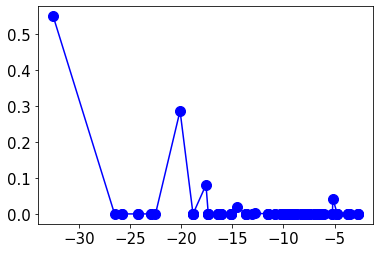

[0.55068588]


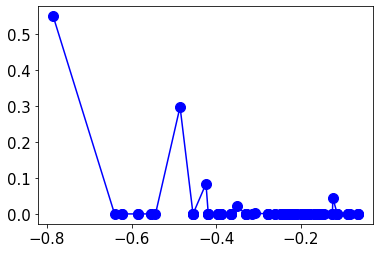

In [2]:
num_sites = 8
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = tfim_1d.generate_ham(num_sites, J, g)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0]])

plt.plot(spectrum, population,'b-o');plt.show()


In [3]:
p0_array = np.array([0.6,0.8]) #initial overlap with the first eigenvector
T0 = 100
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test
T_list_QCELS = 10+T0/2*(np.arange(N_test_QCELS))### circuit depth for QCELS
T_list_QPE = 10+T0*4*(np.arange(N_QPE))###circuit depth for QPE
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 10 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cost_list_avg_QCELS[a1,ix], max_T_QCELS[a1,ix] = \
                    qcels_largeoverlap(spectrum, population, T, NT,
                            Nsample, lambda_prior)#QCELS with time T
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg


For p0= 0.6 For N_test= 1
[0.6]
For p0= 0.6 For N_test= 2
[0.6]
For p0= 0.6 For N_test= 3
[0.6]
For p0= 0.6 For N_test= 4
[0.6]
For p0= 0.6 For N_test= 5
[0.6]
For p0= 0.6 For N_test= 6
[0.6]
For p0= 0.6 For N_test= 7
[0.6]
For p0= 0.6 For N_test= 8
[0.6]
For p0= 0.6 For N_test= 9
[0.6]
For p0= 0.6 For N_test= 10
[0.6]
For p0= 0.8 For N_test= 1
[0.8]
For p0= 0.8 For N_test= 2
[0.8]
For p0= 0.8 For N_test= 3
[0.8]
For p0= 0.8 For N_test= 4
[0.8]
For p0= 0.8 For N_test= 5
[0.8]
For p0= 0.8 For N_test= 6
[0.8]
For p0= 0.8 For N_test= 7
[0.8]
For p0= 0.8 For N_test= 8
[0.8]
For p0= 0.8 For N_test= 9
[0.8]
For p0= 0.8 For N_test= 10
[0.8]


In [5]:
np.savez('result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=T_list_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])